In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch

from bmadx import M_ELECTRON
from bmadx.bmad_torch.track_torch import Beam
from bmadx.coordinates import openPMD_to_bmadx
from bmadx.plot import plot_projections

from initial_beam import create_initial_beam
from training import generate_training_images, train_model

/home/jp/mambaforge/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create initial beam

In [2]:
# create openPMD-beamphysics particle group
par = create_initial_beam('data/gaussian.yaml')

In [3]:
# transform to Bmad phase space coordinates
p0c = 10.0e6 # reference momentum in eV
coords = torch.tensor(openPMD_to_bmadx(par, p0c)).T
print(coords.shape)

# create Bmad-x pytorch beam:
beam = Beam(
    coords,
    s=torch.tensor(0.0),
    p0c=torch.tensor(10.0e6),
    mc2=torch.tensor(M_ELECTRON)
)

# save coords
torch.save(coords, "ground_truth_dist.pt")

torch.Size([10000, 6])


/tmp/ipykernel_97266/1713194906.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  coords = torch.tensor(openPMD_to_bmadx(par, p0c)).T


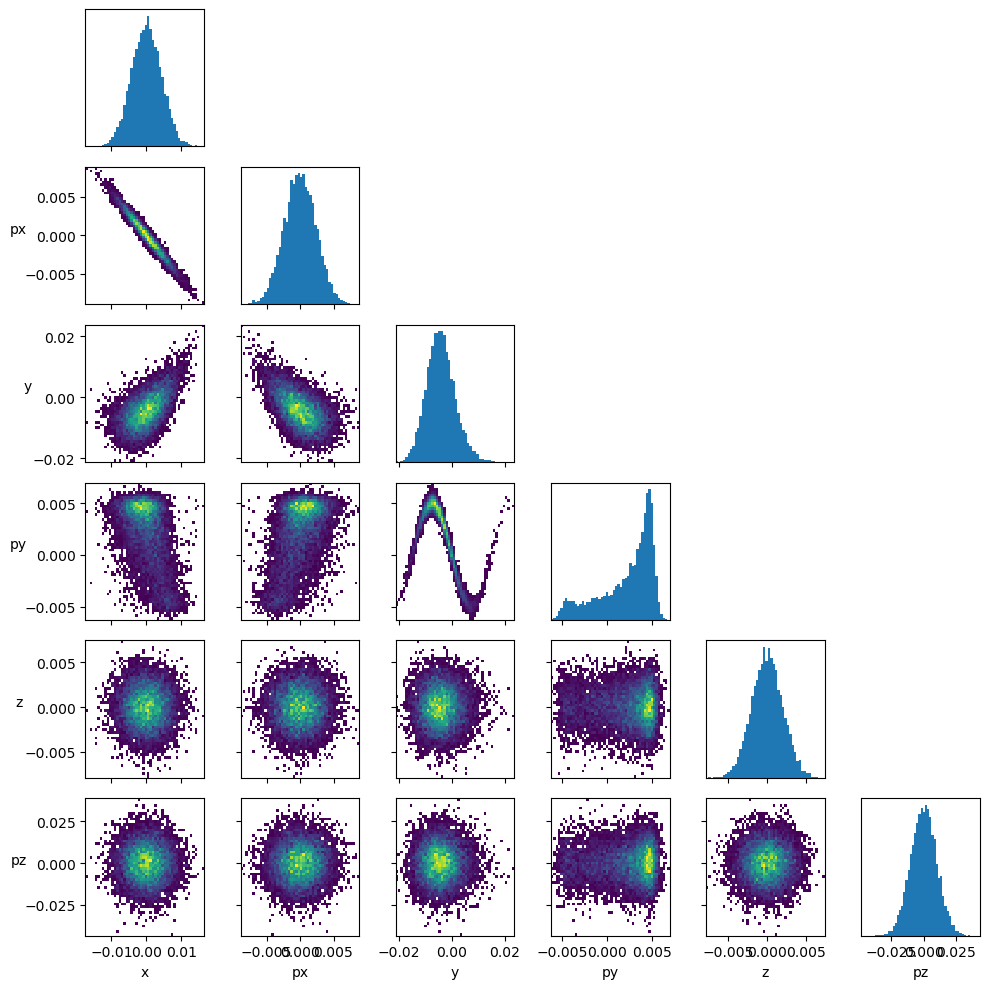

In [4]:
# plot projections
plot_projections(beam.data.detach().numpy(),
                 labels=['x', 'px', 'y', 'py', 'z', 'pz'],
                 bins=50,
                 background=False)

## Generate training images

tensor([-25.], device='cuda:0') tensor(167.7371, device='cuda:0', dtype=torch.float64)
tensor([-22.8947], device='cuda:0') tensor(143.1805, device='cuda:0', dtype=torch.float64)
tensor([-20.7895], device='cuda:0') tensor(120.7163, device='cuda:0', dtype=torch.float64)
tensor([-18.6842], device='cuda:0') tensor(100.3046, device='cuda:0', dtype=torch.float64)
tensor([-16.5789], device='cuda:0') tensor(81.9061, device='cuda:0', dtype=torch.float64)
tensor([-14.4737], device='cuda:0') tensor(65.4817, device='cuda:0', dtype=torch.float64)
tensor([-12.3684], device='cuda:0') tensor(50.9931, device='cuda:0', dtype=torch.float64)
tensor([-10.2632], device='cuda:0') tensor(38.4024, device='cuda:0', dtype=torch.float64)
tensor([-8.1579], device='cuda:0') tensor(27.6722, device='cuda:0', dtype=torch.float64)
tensor([-6.0526], device='cuda:0') tensor(18.7658, device='cuda:0', dtype=torch.float64)
tensor([-3.9474], device='cuda:0') tensor(11.6466, device='cuda:0', dtype=torch.float64)
tensor([-1.84

/home/jp/mambaforge/envs/phase_space_reconstruction/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


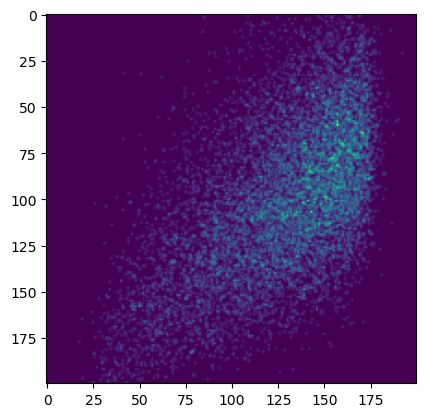

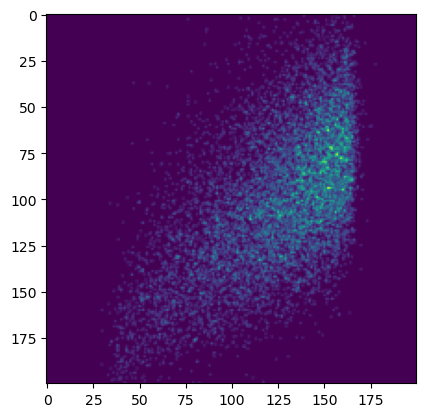

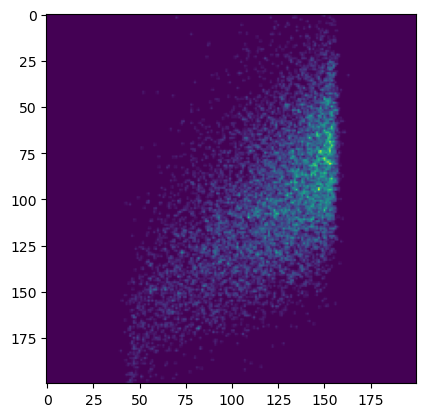

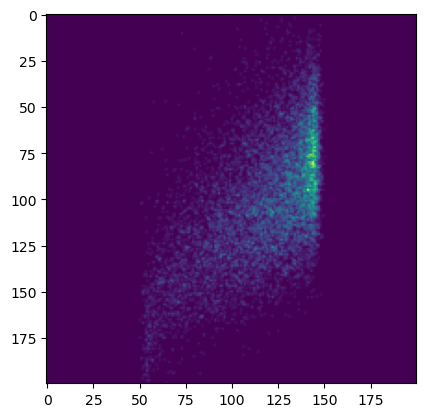

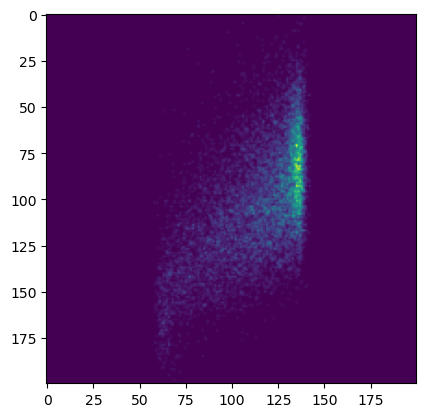

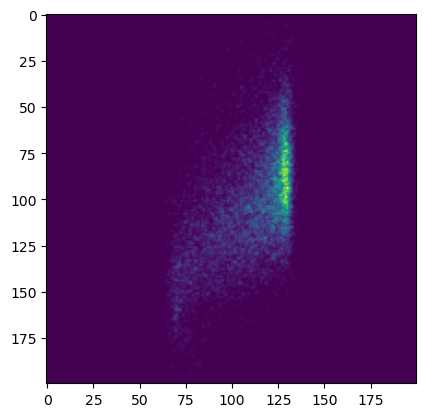

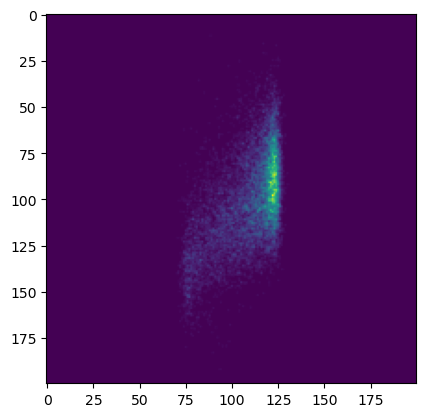

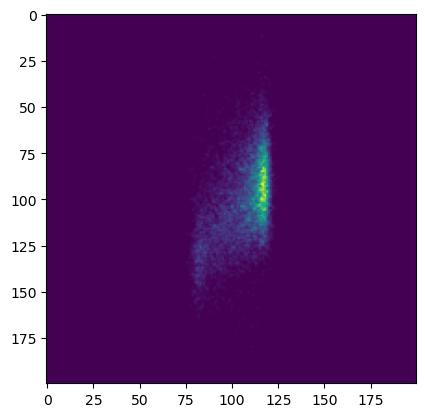

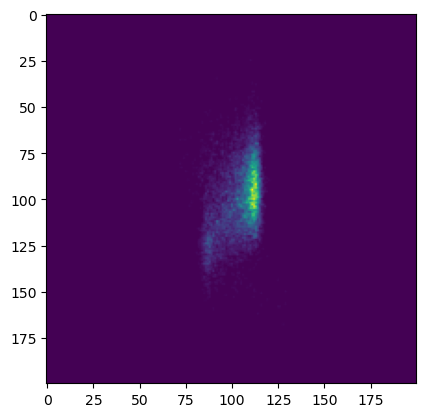

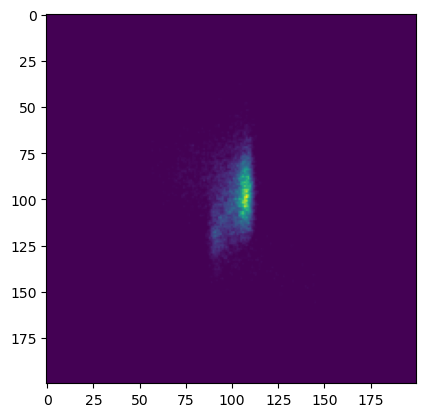

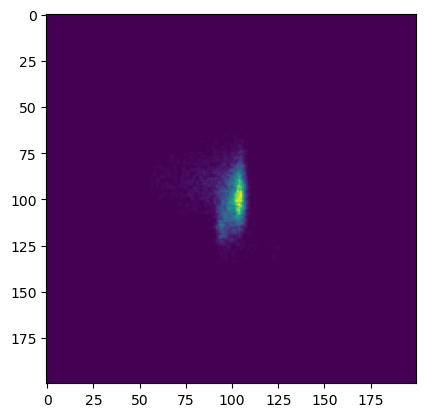

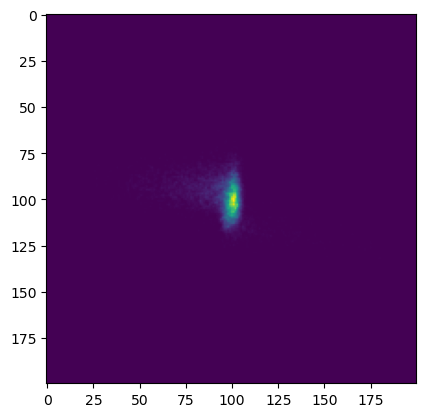

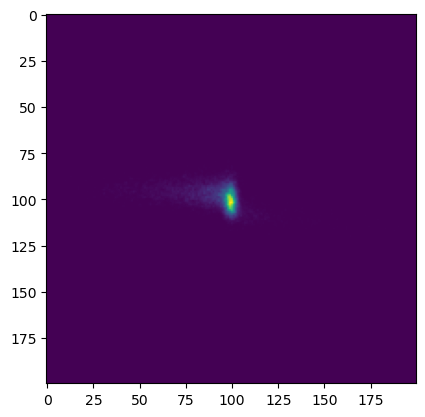

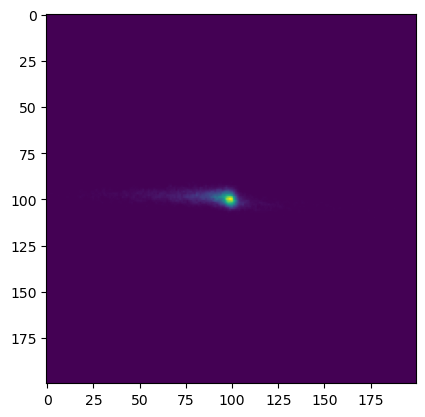

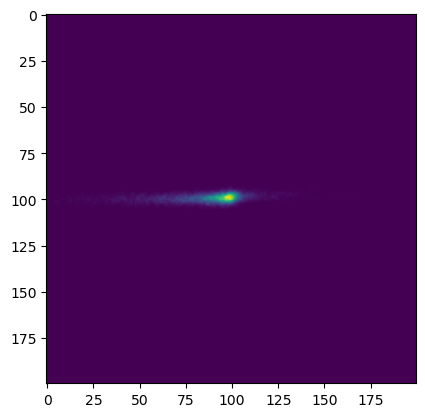

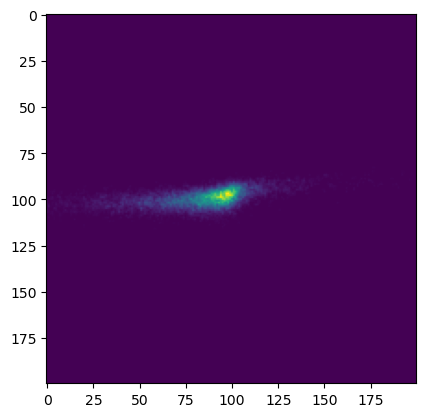

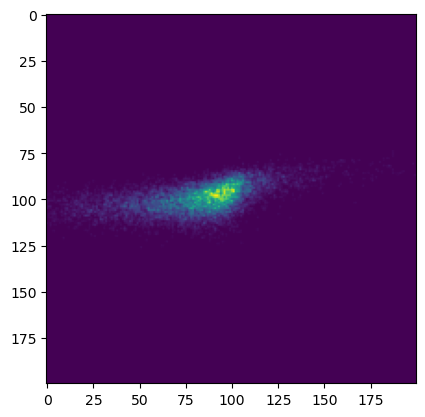

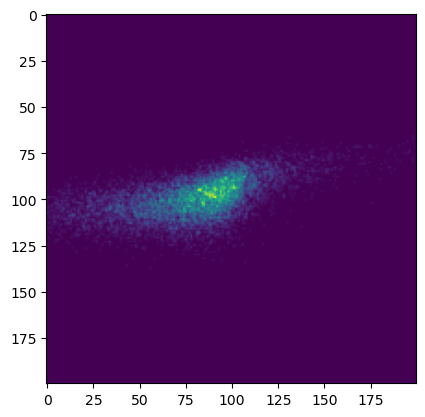

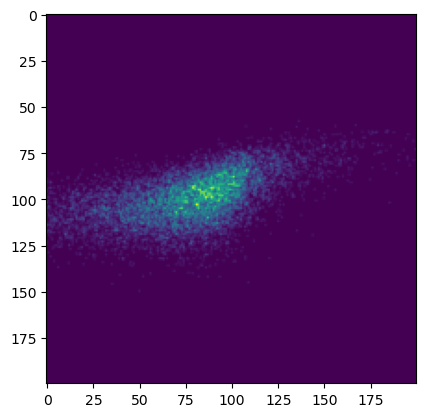

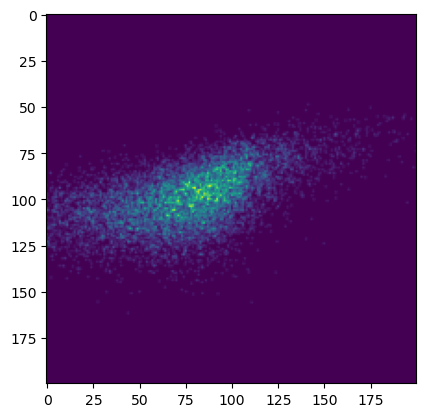

In [5]:
generate_training_images(beam)

0 tensor(4455755.5000, device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(1178379.3750, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(1078495.5000, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(1052258.3750, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(1049604.8750, device='cuda:0', grad_fn=<MulBackward0>)
500 tensor(1011844.1250, device='cuda:0', grad_fn=<MulBackward0>)
600 tensor(1014046., device='cuda:0', grad_fn=<MulBackward0>)
700 tensor(1015150.0625, device='cuda:0', grad_fn=<MulBackward0>)
800 tensor(1000523.3125, device='cuda:0', grad_fn=<MulBackward0>)
900 tensor(990672.7500, device='cuda:0', grad_fn=<MulBackward0>)


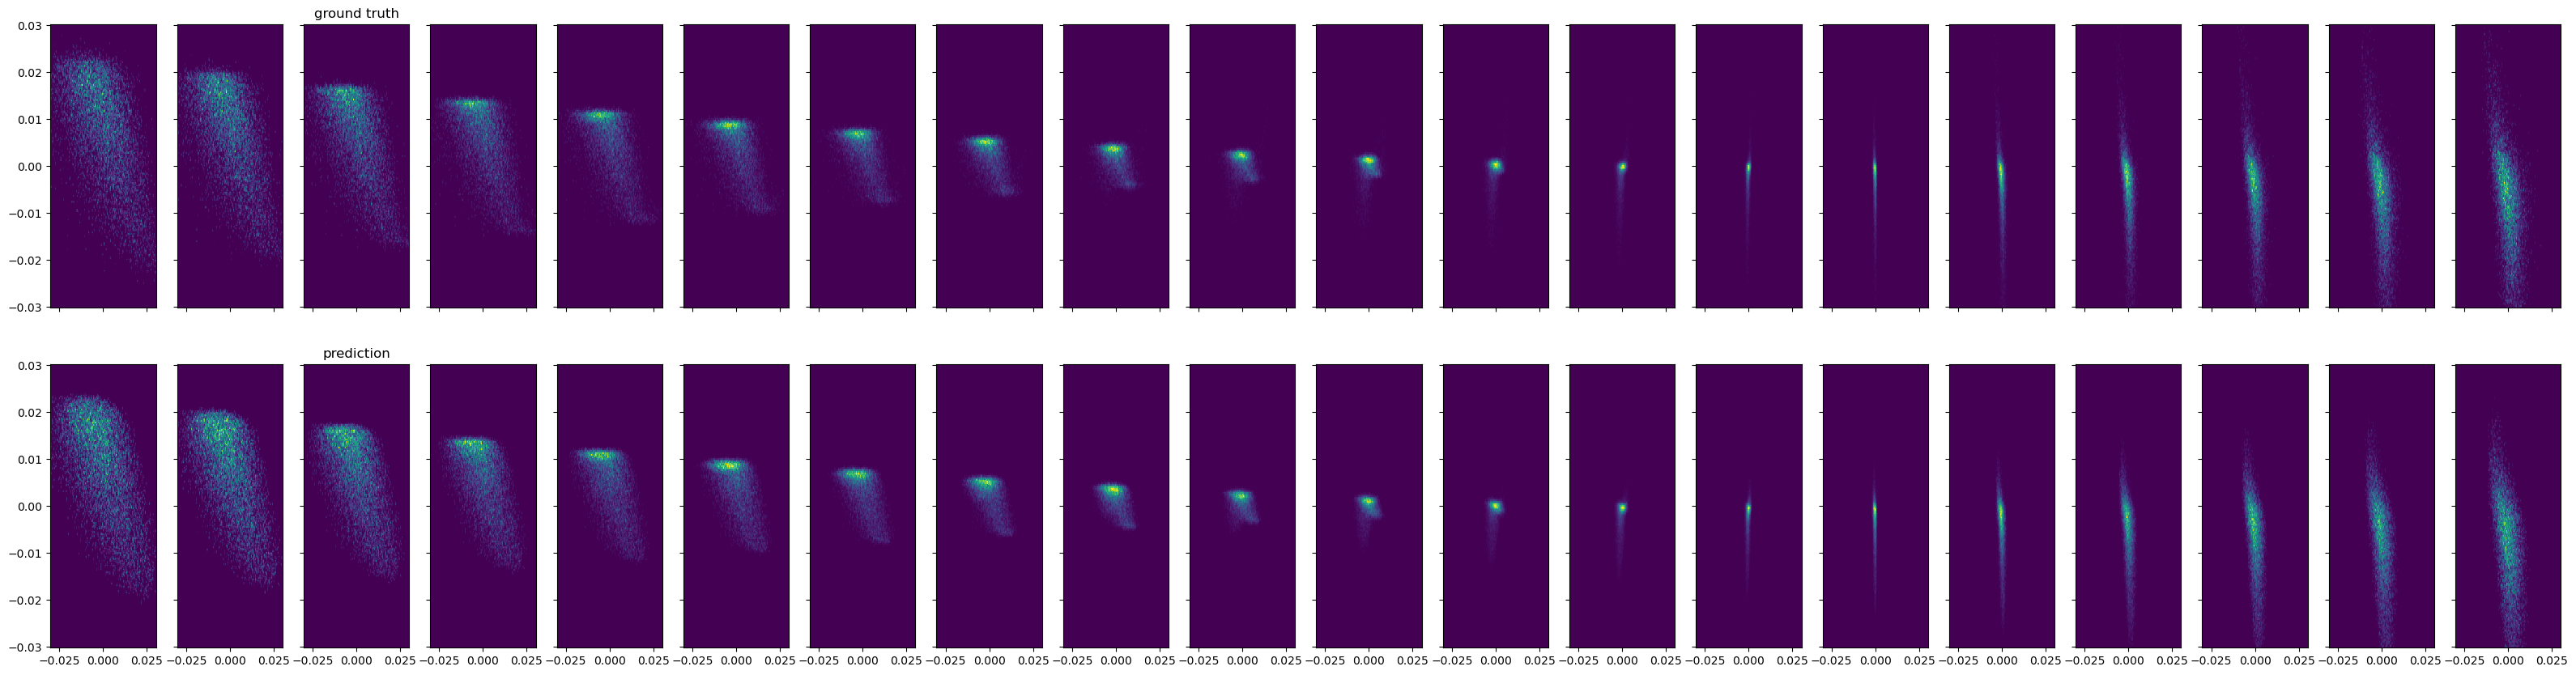

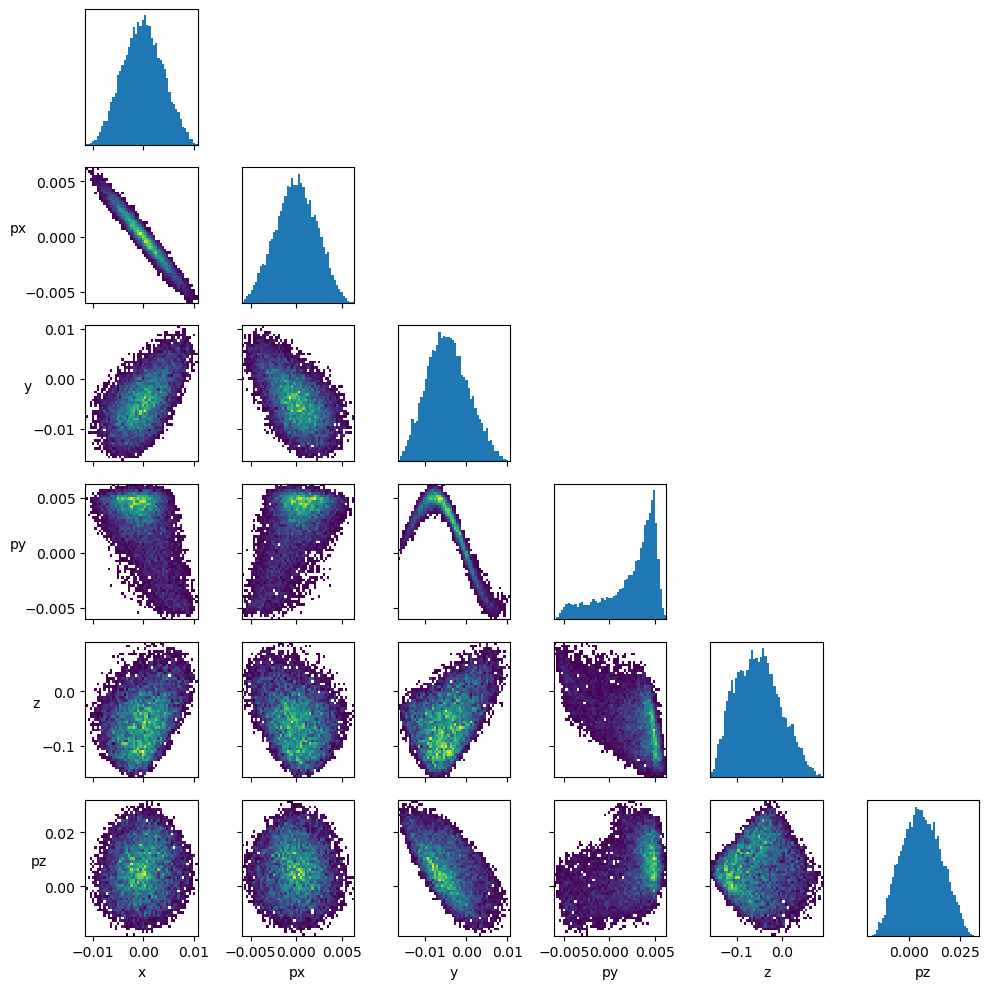

In [6]:
train_model()